<center><h1>Identifying what triggers certain emotions</h1></center>

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import librosa, librosa.display
import os

In [4]:
train_md_df = pd.read_csv("challengeA_data/2022challengeA_train_modified.csv", index_col=[0])

What I'll do is get a uniform number of samples from each class and see if I can find some similarities between the classes.

In [13]:
emotions = sorted(list(train_md_df["emotion"].unique()))

In [14]:
num_samples = 3
samples_from_each_class = train_md_df.groupby("emotion").apply(lambda group: group.sample(num_samples))

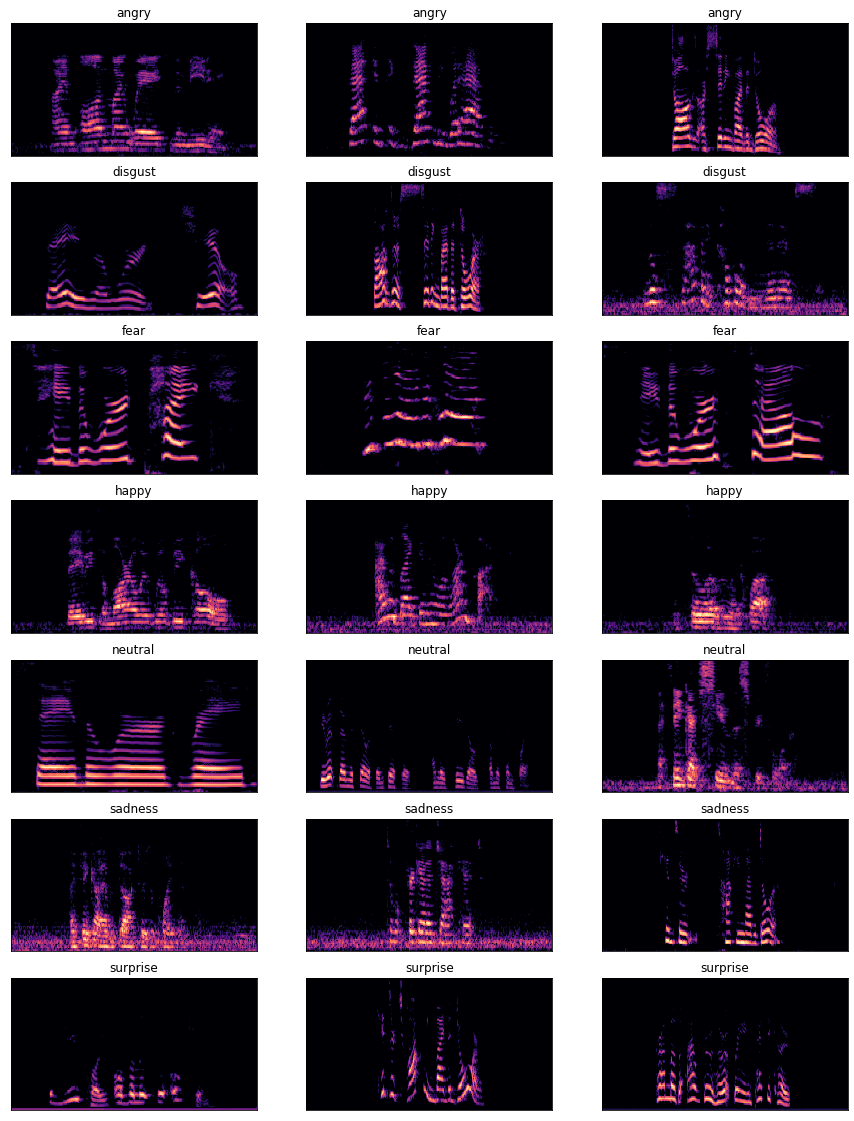

In [26]:
plt.figure(figsize=(15, 20))
rows = len(emotions)
cols = num_samples
for i, (index, row) in enumerate(samples_from_each_class.iterrows()):
    plt.subplot(rows, cols, i+1)          
    file_path = os.path.join("challengeA_data", "train", row["file_id"])
    audio, sr = librosa.load(file_path, sr=16000)
    
    mel_specgram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=512, hop_length=128)
    mel_specgram = librosa.amplitude_to_db(mel_specgram, ref=np.max)
    librosa.display.specshow(mel_specgram)
    plt.title(row["emotion"])
    
    

Some emotions are a bit more difficult to distinguish from others, while some are quite easily identifiable. The one that is most apparent is neutrality, which has a very flat frequency response. Sadness too possesses some repeating characteristics – it seems to occupy relatively lower frequencies. Surprise shows some sudden increases in pitch. Fear has wider gaps between mel-bands. I can't quite find identifiable characteristics in happiness, anger or disgust, though.

I'll also look at the static features to see if I can find anything.

In [47]:
df = pd.read_csv("challengeA_data/ext_features.csv", index_col=[0]).sample(frac=1).reset_index(drop=True)
df.head()

,file_id,encoded_emotion,rms_max,rms_std,rms_mean,magnitude_max,magnitude_std,magnitude_mean,zero_crossing_rate,contrast_6,...,mfcc_mean_0,flatness,cent_max,cent_std,cent_mean,f0_mean,pitch_min,pitch_max,pitch_std,pitch_mean
0,126d229d-2427-4b69-9ef5-4e02f868a12b.wav,3,0.045717,0.010806,0.010211,10.875755,0.328549,0.070423,0.075085,13.805549,...,-371.91434,0.011677,0.047346,0.006660,0.014085,181.886633,0.0,202.92770,90.015750,65.241325
1,147907f4-910b-45ce-8b48-a04a87b3ff1e.wav,2,0.048978,0.008754,0.008812,9.695684,0.272773,0.067549,0.075916,13.627790,...,-359.43330,0.013512,0.033768,0.004500,0.012500,166.198716,0.0,263.48895,102.414764,54.487260
2,8eb64baf-e597-47b3-805f-8e17b3ae30a9.wav,2,0.016456,0.003750,0.004512,2.896019,0.128002,0.034350,0.078978,15.426828,...,-430.26257,0.015919,0.061111,0.010916,0.015873,190.513045,0.0,232.45361,109.044510,106.769420
3,c5233321-3389-4e46-a03e-f9c03d80e9c8.wav,1,0.011787,0.002486,0.004935,2.788279,0.120352,0.036559,0.054979,14.179807,...,-400.20178,0.008695,0.028213,0.002451,0.013889,140.344042,0.0,139.94757,58.394646,41.829170
4,af4cfcaa-73bb-4b8d-a53f-5fc50f9c337a.wav,2,0.020151,0.004584,0.005126,5.122993,0.149233,0.043066,0.085369,15.647070,...,-409.78040,0.032927,0.032867,0.006011,0.012658,144.879406,0.0,140.41043,56.153175,35.037403


I'll decode the integer-encoded emotion to make it easier to analyse.

In [48]:
emotion_column = df["encoded_emotion"].to_numpy()
decoded_emotions = [emotions[i] for i in encoded_emotion_column]
df.drop(["encoded_emotion"], axis=1,inplace=True)
df.insert(1, "emotion",decoded_emotions )
df.head()

,file_id,emotion,rms_max,rms_std,rms_mean,magnitude_max,magnitude_std,magnitude_mean,zero_crossing_rate,contrast_6,...,mfcc_mean_0,flatness,cent_max,cent_std,cent_mean,f0_mean,pitch_min,pitch_max,pitch_std,pitch_mean
0,126d229d-2427-4b69-9ef5-4e02f868a12b.wav,angry,0.045717,0.010806,0.010211,10.875755,0.328549,0.070423,0.075085,13.805549,...,-371.91434,0.011677,0.047346,0.006660,0.014085,181.886633,0.0,202.92770,90.015750,65.241325
1,147907f4-910b-45ce-8b48-a04a87b3ff1e.wav,sadness,0.048978,0.008754,0.008812,9.695684,0.272773,0.067549,0.075916,13.627790,...,-359.43330,0.013512,0.033768,0.004500,0.012500,166.198716,0.0,263.48895,102.414764,54.487260
2,8eb64baf-e597-47b3-805f-8e17b3ae30a9.wav,disgust,0.016456,0.003750,0.004512,2.896019,0.128002,0.034350,0.078978,15.426828,...,-430.26257,0.015919,0.061111,0.010916,0.015873,190.513045,0.0,232.45361,109.044510,106.769420
3,c5233321-3389-4e46-a03e-f9c03d80e9c8.wav,happy,0.011787,0.002486,0.004935,2.788279,0.120352,0.036559,0.054979,14.179807,...,-400.20178,0.008695,0.028213,0.002451,0.013889,140.344042,0.0,139.94757,58.394646,41.829170
4,af4cfcaa-73bb-4b8d-a53f-5fc50f9c337a.wav,happy,0.020151,0.004584,0.005126,5.122993,0.149233,0.043066,0.085369,15.647070,...,-409.78040,0.032927,0.032867,0.006011,0.012658,144.879406,0.0,140.41043,56.153175,35.037403


In [50]:
print("The unique static features\n"+ '-'*30)
prev_column = "" 

for column in df.columns[~df.columns.isin(["file_id", "emotion"])]:
    # I remove numbers from the column name so that I only print out unique features.
    column = ''.join([i for i in column if not i.isdigit()])
    if column == prev_column: continue
    print(column)
    prev_column = column
    

The unique static features
------------------------------
rms_max
rms_std
rms_mean
magnitude_max
magnitude_std
magnitude_mean
zero_crossing_rate
contrast_
mel_
chroma_
medc_delta_
medc_
mfcc_max_
mfcc_std_
mfcc_mean_
flatness
cent_max
cent_std
cent_mean
f_mean
pitch_min
pitch_max
pitch_std
pitch_mean


In [65]:
excluded_columns = [col for col in df.columns if col != "f0_mean" and any(i.isdigit() for i in col)]
df[df.columns[~df.columns.isin(excluded_columns)]].groupby("emotion").mean()

,rms_max,rms_std,rms_mean,magnitude_max,magnitude_std,magnitude_mean,zero_crossing_rate,flatness,cent_max,cent_std,cent_mean,f0_mean,pitch_min,pitch_max,pitch_std,pitch_mean
emotion,,,,,,,,,,,,,,,,
angry,0.079822,0.016847,0.015818,19.093090,0.515726,0.111569,0.117901,0.032074,0.033077,0.006162,0.013005,364.787421,0.0,158.814694,62.015622,42.452574
disgust,0.082696,0.017502,0.016697,19.820006,0.539833,0.116746,0.116759,0.031399,0.034020,0.006346,0.013178,357.321132,0.0,155.644205,60.763857,41.414480
fear,0.081810,0.017586,0.016647,19.700554,0.541092,0.115222,0.116535,0.030704,0.033820,0.006304,0.013106,367.223491,0.0,155.876002,60.814385,41.601485
happy,0.083010,0.017594,0.016712,19.998661,0.542555,0.115994,0.116056,0.030243,0.033158,0.006190,0.012955,362.797223,0.0,156.299751,61.154926,42.271293
neutral,0.081340,0.016894,0.015848,19.707832,0.517617,0.110894,0.117898,0.032455,0.033172,0.006215,0.012978,361.667584,0.0,157.988688,62.152054,42.558265
sadness,0.084933,0.018026,0.016967,20.504130,0.552090,0.117672,0.116610,0.030624,0.033391,0.006288,0.013090,360.070101,0.0,154.549677,59.998186,41.147282
surprise,0.085217,0.018130,0.017097,20.673029,0.556612,0.118633,0.124696,0.034623,0.033901,0.006534,0.013111,399.882981,0.0,150.099849,58.215987,39.112563


The only thing that jumps out is the mean fundamental frequency of samples labelled as 'surprise', which is clearly higher than the rest. Interestingly, surprise was the only emotion that was consistently predicted very precisely by all the models. It seems to be an outlier in some quantities, like zero crossing rate, magnitude. But I otherwise can't identify anything else that could be meaningful. 